In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datafunc import load_psd, load_atomic, assemble_var, data_split_psd

In [4]:
import ngboost
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from ngboost.distns import MultivariateNormal, Normal

### Training NGBoost on PSD and testing on ATOMIC

Loading PSD data


/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Number of samples: 10079


/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


Training samples: 7528
Validating samples: 879
Testing samples: 1666


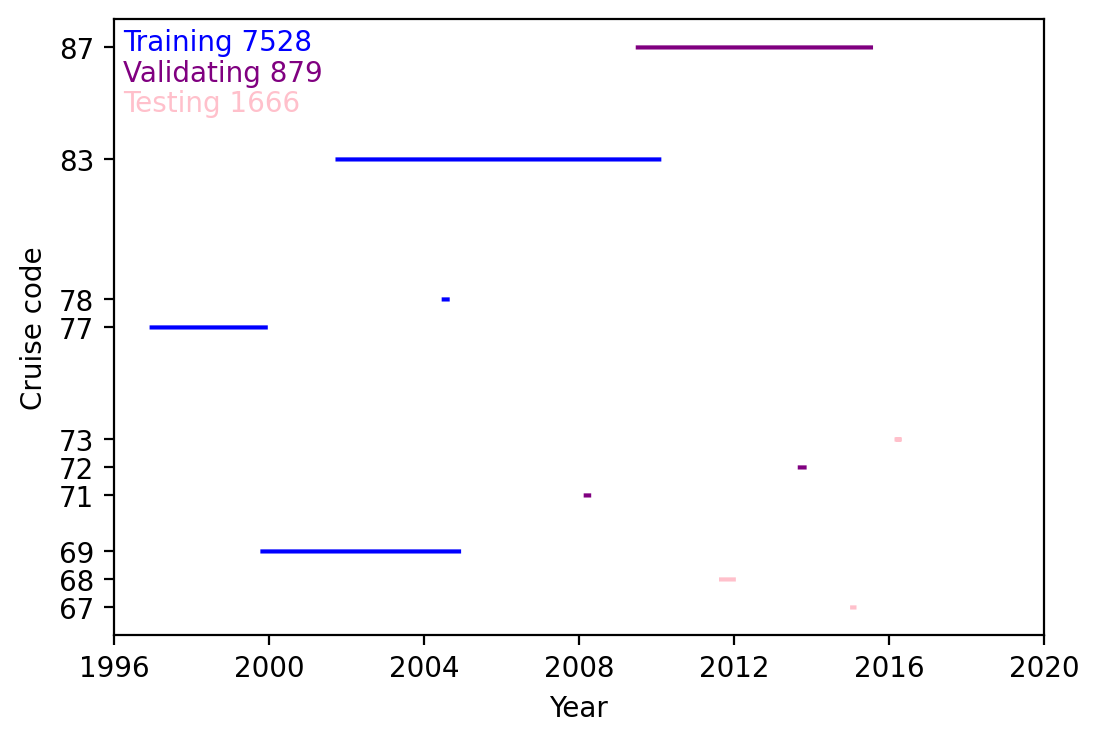

Loading ATOMIC data
Number of samples: 3285


/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


In [2]:
print('Loading PSD data')
ds_psd = load_psd('../MLFLUXES/data/fluxes_all_cruises_compilation.nc')
train, valid, test = data_split_psd(ds_psd, split=[[77, 69, 83, 78], [87, 72, 71], [68, 67, 73]],
                                    PLOT=True, XVIS='time')
X_train, Y_train = assemble_var(train, choice='U_Tdiff_rh')
X_valid, Y_valid = assemble_var(valid, choice='U_Tdiff_rh')
X_test, Y_test = assemble_var(test, choice='U_Tdiff_rh')

print('Loading ATOMIC data')
ds_atomic = load_atomic('../MLFLUXES/data/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')
X_test_atomic, Y_test_atomic = assemble_var(ds_atomic, choice='U_Tdiff_rh')

In [95]:
learner = DecisionTreeRegressor(criterion='friedman_mse',
                                random_state = 2,  
                                max_leaf_nodes = 40,
                                max_depth = 3,
                                min_samples_leaf = 10,
                                max_features = 3
                                )
dist = Normal
score = ngboost.scores.LogScore

DEFAULT_NGBOOST = {"minibatch_frac": 1.0, "learning_rate": 0.05}

ngb = ngboost.NGBoost(
                Dist=dist,
                Score=score,
                Base=learner,
                verbose_eval=10,
                n_estimators=500,
                **DEFAULT_NGBOOST
            )

# def fit(self, X, Y, X_val=None, Y_val=None, sample_weight=None, val_sample_weight=None,
#         train_loss_monitor=None, val_loss_monitor=None, early_stopping_rounds=None,)
ngb.fit(X_train[:,:2], Y_train[:,1], X_val=X_test, Y_val=Y_test[:,1], early_stopping_rounds=1000)


[iter 0] loss=4.5791 val_loss=4.3413 scale=1.0000 norm=9.8950
[iter 10] loss=3.9168 val_loss=3.9997 scale=2.0000 norm=14.5286
[iter 20] loss=3.6465 val_loss=3.7828 scale=2.0000 norm=12.9193
[iter 30] loss=3.4771 val_loss=3.6783 scale=2.0000 norm=12.3736
[iter 40] loss=3.3688 val_loss=3.6456 scale=2.0000 norm=12.0237
[iter 50] loss=3.3230 val_loss=3.6559 scale=2.0000 norm=11.9226
[iter 60] loss=3.2950 val_loss=3.6755 scale=2.0000 norm=11.8593
[iter 70] loss=3.2697 val_loss=3.7107 scale=1.0000 norm=5.8992
[iter 80] loss=3.2535 val_loss=3.7409 scale=1.0000 norm=5.8801
[iter 90] loss=3.2391 val_loss=3.7958 scale=1.0000 norm=5.8710
[iter 100] loss=3.2248 val_loss=3.8478 scale=1.0000 norm=5.8551
[iter 110] loss=3.2185 val_loss=3.8704 scale=1.0000 norm=5.8477
[iter 120] loss=3.2152 val_loss=3.8869 scale=1.0000 norm=5.8446
[iter 130] loss=3.2113 val_loss=3.9122 scale=1.0000 norm=5.8371
[iter 140] loss=3.2062 val_loss=3.9210 scale=1.0000 norm=5.8336
[iter 150] loss=3.1982 val_loss=3.9450 scale=

In [ ]:
# The old code that was not working well 
# X = np.hstack([np.reshape(ds_clean.U.values.astype('float32'),(-1,1)), np.reshape(ds_clean.tsnk.values.astype('float32'),(-1,1)),
#                np.reshape(ds_clean.ta.values.astype('float32'),(-1,1)), np.reshape(ds_clean.qa.values.astype('float32'),(-1,1))])
# Y = np.hstack([np.reshape(-ds_clean.hsc.values.astype('float32'),(-1,1)), 
#                np.reshape(-ds_clean.hsb.values.astype('float32'),(-1,1))])
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
# ngb_tau = NGBRegressor(Base=learner, n_estimators=300, learning_rate=0.01)
# ngb_tau.fit(X_train, Y_train[:,1])

### Visualize prediction
#### Mean

In [30]:
from utils import mse_r2
def plot_pred(X, Y_truth, Y_pred_mean, Y_pred_std, ax, xplot='U', yplot='tau', model_label='NGBoost'):
    
    # select x to plot
    if xplot == 'Tdiff': x = X[:,1]
    elif xplot == 'U': x = X[:,0]
    
    if yplot == 'tau':
        ax.plot(x, Y_truth, '.', markersize=1, alpha=0.5, label='Measured')
        ax.plot(x, Y_pred_mean, '.', markersize=1, alpha=0.5, 
               label=model_label+', MSE=%.3f, r2=%.3f' %mse_r2(Y_pred_mean,Y_truth))
        # ax.errorbar(x, mean, yerr=std, fmt='.', markersize=1, alpha=0.5, 
        #         label=model_label+', mse=%.3f, r2=%.3f' %mse_r2(mean,Y_truth))
        ax.set_ylim([-0.1,0.6]); ax.set_ylabel('Momentum flux ($N/m^2$)')
              
    if yplot == 'hs':
       ax.plot(x, Y_truth, '.', markersize=1, alpha=0.5, label='Measured')
       ax.plot(x, Y_pred_mean, '.', markersize=1, alpha=0.5, 
               label=model_label+', MSE=%.3f, r2=%.3f' %mse_r2(Y_pred_mean,Y_truth))
       # ax.errorbar(x, mean, yerr=std, fmt='.', markersize=1, alpha=0.5, 
       #         label=model_label+', mse=%.3f, r2=%.3f' %mse_r2(mean,Y_truth))
       ax.set_ylim([-40,20]); ax.set_ylabel('Sensible heat flux ($W/m^2$)')
       
    if yplot == 'hl':
       ax.plot(x, Y_truth, '.', markersize=1, alpha=0.5, label='Measured')
       ax.plot(x, Y_pred_mean, '.', markersize=1, alpha=0.5, 
               label=model_label+', MSE=%.3f, r2=%.3f' %mse_r2(Y_pred_mean,Y_truth))
       # ax.errorbar(x, mean, yerr=std, fmt='.', markersize=1, alpha=0.5, 
       #         label=model_label+', mse=%.3f, r2=%.3f' %mse_r2(mean,Y_truth))
       ax.set_ylim([-300,50]); ax.set_ylabel('Latent heat flux ($W/m^2$)')
    
    if xplot == 'U': ax.set_xlabel('Wind speed ($m/s$)'); ax.set_xlim([0,20])
    elif xplot == 'Tdiff': ax.set_xlabel('Temp. diff. ($\degree C$)');  ax.set_xlim([-5,2])
    elif xplot == 'rh': ax.set_xlabel('Relative humidity (%)');  ax.set_xlim([40,100])

    ax.legend(fancybox=False, loc='upper left')
    return ax

<Axes: xlabel='Temp. diff. ($\\degree C$)', ylabel='Momentum flux ($N/m^2$)'>

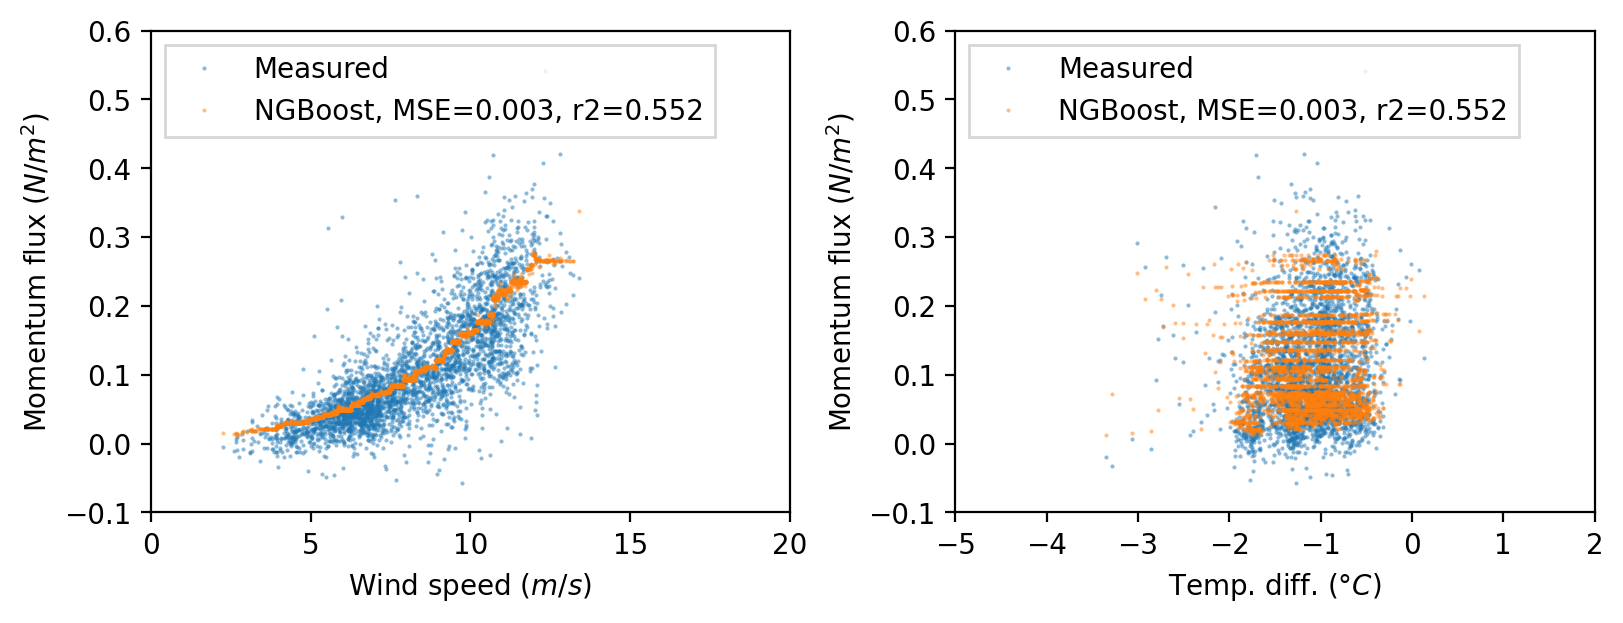

In [80]:
fig,axes = plt.subplots(1, 2, figsize=[8,3], dpi=200, constrained_layout=True)

# Bulk on PSD testing
# ax = axes[0]
# plot_pred(X_test, Y_test[:,0], Y_pred_mean=test.taubx.values.squeeze(), Y_pred_std=std, 
#           ax=ax, xplot='U', yplot='tau', model_label='Bulk')
# ax = axes[1]
# plot_pred(X_test, Y_test[:,0], Y_pred_mean=test.taubx.values.squeeze(), Y_pred_std=std, 
#           ax=ax, xplot='Tdiff', yplot='tau', model_label='Bulk')

# NGBoost on PSD testing
# model = ngb
# mean = model.predict(X_test[:,:2]); 
# dist = model.pred_dist(X_test[:,:2]); std = dist.std()
# ax = axes[0]
# # For momentum Y_test[:,0], for sensible heat Y_test[:,1]
# plot_pred(X_test, Y_test[:,0], Y_pred_mean=mean, Y_pred_std=std, ax=ax, xplot='U', yplot='tau', model_label='NGBoost')
# ax = axes[1]
# plot_pred(X_test, Y_test[:,0], Y_pred_mean=mean, Y_pred_std=std, ax=ax, xplot='Tdiff', yplot='tau', model_label='NGBoost')

# Bulk on ATOMIC testing
# ax = axes[0]
# plot_pred(X_test_atomic, Y_test_atomic[:,0], Y_pred_mean=ds_atomic.taubx.values.squeeze(), Y_pred_std=None, 
#           ax=ax, xplot='U', yplot='tau', model_label='Bulk')
# ax = axes[1]
# plot_pred(X_test_atomic, Y_test_atomic[:,0], Y_pred_mean=ds_atomic.taubx.values.squeeze(), Y_pred_std=None, 
#           ax=ax, xplot='Tdiff', yplot='tau', model_label='Bulk')

# NGBoost on ATOMIC testing
model = ngb
mean = model.predict(X_test_atomic); 
dist = model.pred_dist(X_test_atomic); std = dist.std()
ax = axes[0]
plot_pred(X_test_atomic, Y_test_atomic[:,0], Y_pred_mean=mean, Y_pred_std=std, ax=ax, 
          xplot='U', yplot='tau', model_label='NGBoost')
ax = axes[1]
plot_pred(X_test_atomic, Y_test_atomic[:,0], Y_pred_mean=mean, Y_pred_std=std, ax=ax, 
          xplot='Tdiff', yplot='tau', model_label='NGBoost')

#### Variance landscape

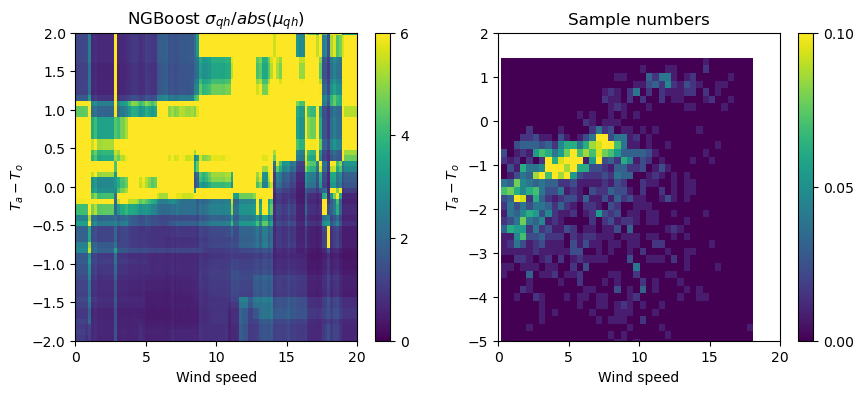

In [105]:
# TODOs
# Write a modular code where data assembly is nicer
# Write a model class which has a train function and print out testing errors too 
# Use relative humidity (0,1)
fig,axes = plt.subplots(1,2,figsize=[10,4])

ax = axes[0]
x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
X_feed = np.hstack([np.reshape(x1_mesh,(-1,1)), np.reshape(x2_mesh,(-1,1))])
Y_dist = ngb.pred_dist(X_feed)
Y_std_pred = Y_dist.std().reshape(100,100)
Y_mean_pred = Y_dist.mean().reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred/abs(Y_mean_pred), vmax=6, vmin=0)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
ax.set_title(r'NGBoost $\sigma_{qh}/abs(\mu_{qh})$')
plt.colorbar(img,ticks=[0,2,4,6])

ax = axes[1]
img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
ax.set_xlim([0,20]); ax.set_ylim([-5,2])
ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
ax.set_title('Sample numbers')
plt.colorbar(img[-1], ticks=[0,0.05,0.1])
plt.show()

### Train a multivariate model 

In [44]:
p = 3
# Create the mvn class
mvn_dist = MultivariateNormal(p)
score = ngboost.scores.LogScore

learner = DecisionTreeRegressor(criterion='friedman_mse',
                                random_state = 2,  
                                max_leaf_nodes = 40,
                                max_depth = 3,
                                min_samples_leaf = 10,
                                max_features = 3
                                )

DEFAULT_NGBOOST = {"minibatch_frac": 1.0, "learning_rate": 0.05}

ngb_mv = ngboost.NGBoost(
                Dist=mvn_dist,
                Score=score,
                Base=learner,
                verbose_eval=10,
                n_estimators=800,
                **DEFAULT_NGBOOST
            )

ngb_mv.fit(X_train[:,:2], Y_train)

# If one wants a list of predicted MVN scipy distributions:
# model.pred_dist(X).scipy_distribution()

[iter 0] loss=8.9264 val_loss=0.0000 scale=0.0625 norm=2.5873
[iter 10] loss=7.9435 val_loss=0.0000 scale=2.0000 norm=74.0570
[iter 20] loss=7.1571 val_loss=0.0000 scale=2.0000 norm=63.4048
[iter 30] loss=6.7243 val_loss=0.0000 scale=0.2500 norm=7.6069
[iter 40] loss=6.4907 val_loss=0.0000 scale=2.0000 norm=60.0290
[iter 50] loss=6.3089 val_loss=0.0000 scale=1.0000 norm=29.7476
[iter 60] loss=6.2413 val_loss=0.0000 scale=1.0000 norm=29.6641
[iter 70] loss=6.1902 val_loss=0.0000 scale=2.0000 norm=59.1968
[iter 80] loss=6.1476 val_loss=0.0000 scale=1.0000 norm=29.5317
[iter 90] loss=6.1175 val_loss=0.0000 scale=1.0000 norm=29.4852
[iter 100] loss=6.0950 val_loss=0.0000 scale=1.0000 norm=29.4455
[iter 110] loss=6.0731 val_loss=0.0000 scale=1.0000 norm=29.4050
[iter 120] loss=6.0570 val_loss=0.0000 scale=1.0000 norm=29.3564
[iter 130] loss=6.0402 val_loss=0.0000 scale=0.5000 norm=14.6597
[iter 140] loss=6.0318 val_loss=0.0000 scale=0.2500 norm=7.3229
[iter 150] loss=6.0210 val_loss=0.0000 

In [7]:
mean_mv = ngb_mv.predict(X_test)
# model = model.pred_dist(X_train).scipy_distribution()
# mean_uv_tau = model_uv_tau.predict(X_test)
# mean_uv_hs = model_uv_hs.predict(X_test)
# mean_uv_hl = model_uv_hl.predict(X_test)

In [36]:
model = ngb_mv
means = model.predict(X_test_atomic); 
dists = model.pred_dist(X_test_atomic).scipy_distribution()
covs = [dist.cov for dist in dists]
std_y1 = [cov[0,0]**0.5 for cov in covs]
std_y2 = [cov[1,1]**0.5 for cov in covs]
std_y3 = [cov[2,2]**0.5 for cov in covs]

<Axes: xlabel='Temp. diff. ($\\degree C$)', ylabel='Sensible heat flux ($W/m^2$)'>

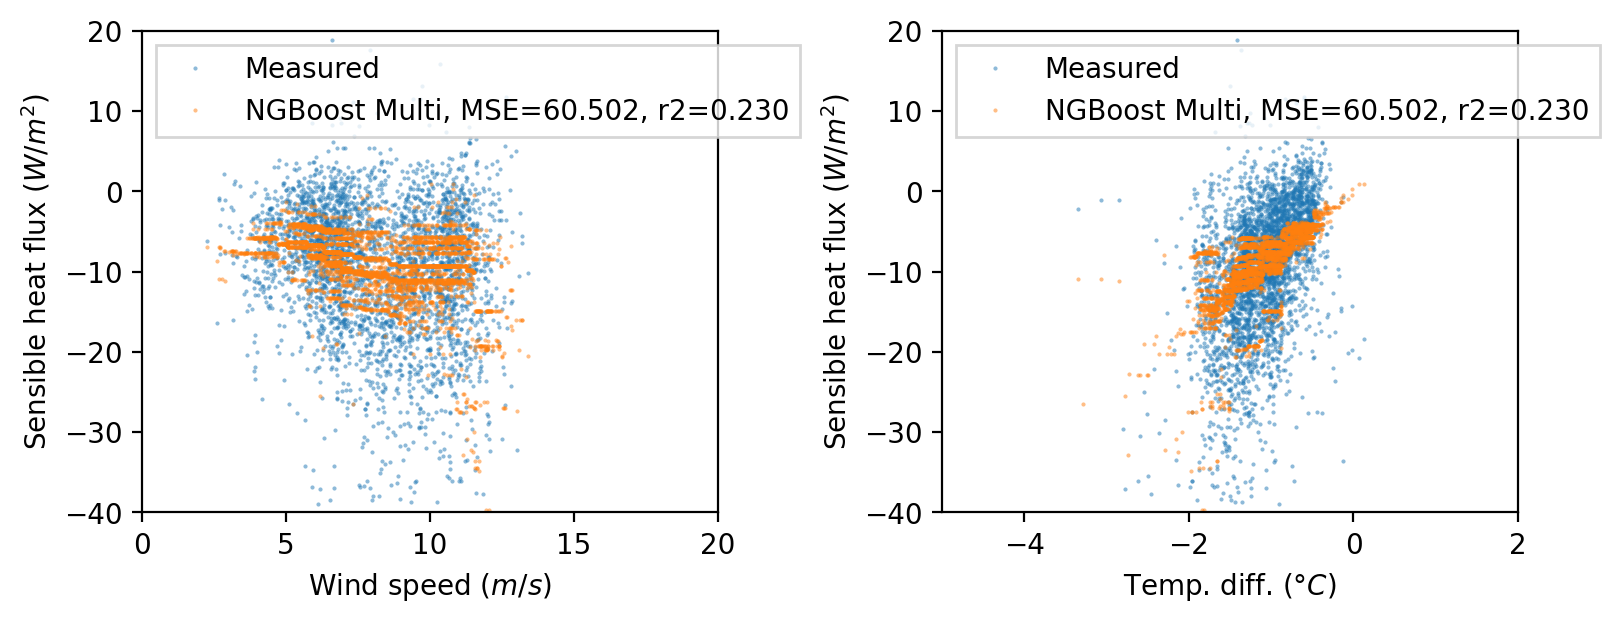

In [37]:
fig,axes = plt.subplots(1, 2, figsize=[8,3], dpi=200, constrained_layout=True)

ax = axes[0]
plot_pred(X_test_atomic, Y_test_atomic[:,1], Y_pred_mean=mean[:,1], Y_pred_std=std_y2, ax=ax, 
          xplot='U', yplot='hs', model_label='NGBoost Multi')
ax = axes[1]
plot_pred(X_test_atomic, Y_test_atomic[:,1], Y_pred_mean=mean[:,1], Y_pred_std=std_y2, ax=ax, 
          xplot='Tdiff', yplot='hs', model_label='NGBoost Multi')

In [46]:
# For variance landscape
x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
X_feed = np.hstack([np.reshape(x1_mesh,(-1,1)), np.reshape(x2_mesh,(-1,1))])

means = model.predict(X_feed); 
dists = model.pred_dist(X_feed).scipy_distribution()
covs = [dist.cov for dist in dists]
std_y1 = np.array([cov[0,0]**0.5 for cov in covs])
std_y2 = np.array([cov[1,1]**0.5 for cov in covs])
std_y3 = np.array([cov[2,2]**0.5 for cov in covs])

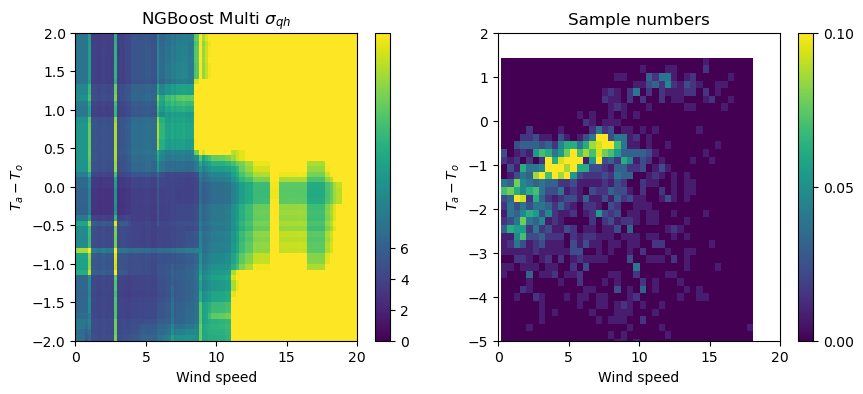

In [52]:
fig,axes = plt.subplots(1,2,figsize=[10,4])
ax = axes[0]

# Momentum
# Y_std_pred = std_y1.reshape(100,100)
# Y_mean_pred = means[:,0].reshape(100,100)
# Heat
Y_std_pred = std_y2.reshape(100,100)
Y_mean_pred = means[:,1].reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred, vmax=20, vmin=0)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
ax.set_title(r'NGBoost Multi $\sigma_{qh}$')
plt.colorbar(img,ticks=[0,2,4,6])

ax = axes[1]
img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
ax.set_xlim([0,20]); ax.set_ylim([-5,2])
ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
ax.set_title('Sample numbers')
plt.colorbar(img[-1], ticks=[0,0.05,0.1])
plt.show()

In [24]:
covs[0]

array([[ 2.00772172e-03, -3.15832159e-02, -6.77600115e-01],
       [-3.15832159e-02,  5.92047934e+01,  8.87334165e+01],
       [-6.77600115e-01,  8.87334165e+01,  2.35493192e+03]])